# Intent Clustering, Document Embeddings, and Unsupervised Learning

In this notebook, I take the preprocessed and tokenized data in the previous notebook and try to assign labels for each Tweet in the dataset by using meaningful document embedding methods and unsupervised learning methods such as K-Means, DBScan, and LDA.

In [ ]:
# We need more packages!
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")
# Unsupervised Learning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from zeugma.embeddings import EmbeddingTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
# Word Embeddings
import gensim
print(f'gensim: {gensim.__version__}')
# Storing as objects via serialization
from tempfile import mkdtemp
# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

Pandas: 1.0.1
Numpy: 1.18.1


## Previewing the current data we are working with

In [5]:
!ls objects

labels_grand.pkl      wcss-kmeans.pkl
processed_inbound.pkl wcss_grand.pkl


In [1]:
# Loading in the already saved processed dataset
processed_inbound = pd.read_pickle('processed_inbound.pkl')

NameError: name 'pd' is not defined

In [135]:
# We start with this data, here's the preview
processed_X_train.head()

38343    [ever, since, late, watch, o, update, get, not...
26943    [work, apple, support, get, result, paid, deve...
18403    [many, stupid, bug, new, update, ready, throw,...
19883    [take, 7, plus, charger, get, ready, work, tim...
87560    [log, itunes, account, lap-fucking-top, god, g...
Name: inbound_text, dtype: object

In [136]:
processed_X_test.head()

39227    [possibile, save, photo, dropbox, photo, app, ...
96901    [can, not, seem, make, genius, bar, appt, onli...
32619    [swear, ..., 3rd, io, update, make, iphone, ba...
71706    [phone, tell, wifi, password, network, wrong, ...
478      [wire, thing, update, 6, gig, available, 10, k...
Name: inbound_text, dtype: object

In [ ]:

cachedir = mkdtemp()

In [78]:
# We give our estimators as a list of tuples: name:function.
estimators = [('embedding', EmbeddingTransformer()),
              ('model', KMeans())]

pipe = Pipeline(estimators, memory = cachedir)

params = [
    {'embedding': [EmbeddingTransformer()], 'model': [KMeans()],
    'embedding__model':['glove'],'model__n_cluster': [8]},
    {'embedding':[EmbeddingTransformer()], 'model': [LatentDirichletAllocation()],
    'embedding_model':['glove']}
]

grid = GridSearchCV(pipe, param_grid=params)

In [ ]:
fittedgrid = grid.fit(X_train, y_train)

In [ ]:
fittedgrid.best_estimator_

In [ ]:
fittedgrid.cv_results_['mean_test_score']

# Embedding and Vectorizing in a Meaningful Way

It is incredibly important to be able to represent this text data as in a meaningful way as to have similar Tweets have closer distances than different Tweets that have different intents. However, since I am working with sequences, I could not just embed their individual words because that will result in a different dimensionality for every single Tweet, and this is something that unsupervised learning algorithms do not know how to handle.

Some of these document embedding methods are:
* BERT
* FastText
* Doc2Vec
* Word2Vec

### 1. Count Vectorization

The easiest way to represent a document as a vector is with a bagofwords CountVectorizer. This will turn each document to be a 1D array, which I think is a good starting point for putting into my clustering algorithms. Let's see how it does. 

The count vectorizer only accepts the Series if the document is represented as a String, not a tokenized list. So I do that change here:

In [140]:
# Representing my tokenized data as String documents and storing it into a variable
string_processed_X_train = processed_X_train.progress_apply(" ".join)
string_processed_X_test = processed_X_test.progress_apply(" ".join)

I set the min_df paramater to 5 to only include terms that occur more than 5 times in my Count Vectorized data.

In [138]:
string_processed_X_train

38343    ever since late watch o update get notificatio...
26943    work apple support get result paid development...
18403    many stupid bug new update ready throw iphone ...
19883    take 7 plus charger get ready work time get ca...
87560    log itunes account lap-fucking-top god green e...
                               ...                        
33943    can not connect disconnect movie anywhere acco...
92303    hey put manual fix ️ use word ️ phone funny th...
6618     apple watch 3 work caribbean prepare cruise ne...
90430    reason phone keep glitching crash reset 7 plus...
29828    fix screen recorder like stop record sound som...
Name: inbound_text, Length: 52659, dtype: object

In [141]:
string_processed_X_test

39227    possibile save photo dropbox photo app mean ap...
96901    can not seem make genius bar appt online wife ...
32619      swear ... 3rd io update make iphone bad bad bad
71706    phone tell wifi password network wrong phone n...
478              wire thing update 6 gig available 10 know
                               ...                        
57009          get ️ emoji fix letter ️ get together apple
96688    iphone let use wifi imessage facetime app stor...
189      hey wonder new update phone go banana day far ...
79685                take week change password get old one
11767    since update io 11 camera work 🙄 anybody else ...
Name: inbound_text, Length: 25951, dtype: object

In [139]:
# Vectorizing the data with Count Vectorizer
bagofwords = CountVectorizer(min_df = 5).fit(string_processed_X_train)
X_train_cv = bagofwords.transform(string_processed_X_train)
X_train_cv # Output will be a sparse matrix

<52659x4181 sparse matrix of type '<class 'numpy.int64'>'
	with 532614 stored elements in Compressed Sparse Row format>

Before we move on, let's visualize and do what we did earlier and view the top 10 most frequent words in my processed data.

This tells me most of the customer queries are about phones, particularly iOS and battery fixes. We also see thanks rank quite high, which is a good thing because it might indicate gratitude (which indicates a closing intent for my chatbot). Hi (rank 44) and hey (rank 25) classifies a greeting intent, and it's good to see that they appear a lot of times. Things are looking promising right now, but we wouldn't be able to see the quality until we actually start clustering.

### TFIDF

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
tfidf = TfidfVectorizer(min_df=5, ngram_range = (1,3))
tfidf.fit(processed_X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [63]:
# Storing tfidf data and transforming them into sparse matrices
X_train_tfidf = tfidf.transform(processed_X_train)
X_test_tfidf = tfidf.transform(processed_X_test)

In [65]:
X_train_tfidf

<52659x23422 sparse matrix of type '<class 'numpy.float64'>'
	with 848948 stored elements in Compressed Sparse Row format>

In [66]:
X_test_tfidf

<25951x23422 sparse matrix of type '<class 'numpy.float64'>'
	with 407769 stored elements in Compressed Sparse Row format>

## Pretrained word embeddings
Useful source: https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

* https://pypi.org/project/zeugma/0.41/
* https://github.com/nkthiebaut/zeugma

Bag of words lose many of the subtleties such as word ordering. This is why I will try these other text vectorization methods:

### GloVe
I am going to use multiple word embeddings to vectorize my text in different ways, and then test which one is the best word embedding to use, starting with the Glove word embedding. GloVe is an unsupervised learning algorithm for getting vector representations for words.

However, as a disclaimer, I won't be using this one because my clustering algorithms only work when each tweet is one point, and this is  a word transformer. I am leaving this part in my notebook as a progress log.

In [46]:
glove = EmbeddingTransformer('glove')

In [48]:
# Applying it to the entire training data
X_train_glove = processed_X_train.progress_apply(glove.transform)

In [73]:
cosine_similarity(X_train_glove.iloc[0],X_train_glove.iloc[1])

array([[0.8130621 , 0.5656479 , 0.6877206 , 0.86405647, 0.64206785,
        0.8817774 , 0.73349965, 0.48393366, 0.35663372, 0.6771863 ,
        0.86187154, 0.42652112, 0.6414212 , 0.4901102 ],
       [0.8943309 , 0.54043406, 0.7118227 , 0.9206827 , 0.7442706 ,
        0.88108957, 0.8326488 , 0.55309945, 0.52669424, 0.73307854,
        0.89418006, 0.56818885, 0.5923007 , 0.5121745 ],
       [0.71216136, 0.7541538 , 0.7458268 , 0.64471316, 0.73993534,
        0.592138  , 0.6949012 , 0.7711556 , 0.5190994 , 0.8070698 ,
        0.81427187, 0.64189667, 0.7493244 , 0.35251677],
       [0.8264686 , 0.6154053 , 0.7340815 , 0.8245878 , 0.6410612 ,
        0.8773806 , 0.6969551 , 0.5448388 , 0.33315665, 0.7115154 ,
        0.92361647, 0.40779543, 0.641692  , 0.3772235 ],
       [0.16007815, 0.36551693, 0.18245363, 0.15790792, 0.21499912,
        0.26659784, 0.23867299, 0.09836231, 0.16759305, 0.1912168 ,
        0.2684987 , 0.12097125, 0.35895252, 0.08930411],
       [0.65246534, 0.63552326, 0.7

Cosine similarity could be 0 if they are perpendicular. 

In [90]:
#Doing the same for the testing data
X_test_glove = processed_X_test.progress_apply(glove.transform)

In [92]:
X_train_glove

38343    [[0.11597, 0.066013, 0.30173, -0.65542, 0.0217...
26943    [[-0.41814, 1.1661, 0.30718, -0.77125, 0.53066...
18403    [[1.0472, 0.75721, 0.39005, 0.18197, 0.02607, ...
19883    [[-0.39819, 0.92849, 1.1194, -0.13217, -0.2980...
87560    [[0.016798, 1.0559, 1.8648, -0.68766, -0.02673...
                               ...                        
33943    [[0.13191, -0.01726, -0.86139, -0.43648, -1.29...
92303    [[-0.011587, 0.6575, 0.19401, 0.1987, -0.69354...
6618     [[0.85337, 0.011645, -0.033377, -0.31981, 0.26...
90430    [[0.43525, 0.41565, -0.0049016, 0.33494, -0.09...
29828    [[0.44877, 1.4266, -0.40778, 0.38396, -0.01416...
Name: inbound_text, Length: 63412, dtype: object

In [91]:
X_train_glove.iloc[0]

array([[ 1.1597e-01,  6.6013e-02,  3.0173e-01, -6.5542e-01,  2.1744e-02,
        -4.5297e-01,  2.1000e+00, -1.9427e-01, -1.0320e+00, -6.6347e-01,
         3.0398e-01,  4.0125e-01, -4.8677e+00,  1.4501e-01, -2.1228e-01,
         1.0987e+00,  6.5365e-01, -3.7288e-01,  1.5131e-01, -6.3025e-01,
         2.3052e-01,  6.0988e-01,  1.2155e-01,  4.6332e-01,  2.0091e-01],
       [ 5.1860e-02,  8.6367e-01,  1.1402e+00, -7.1556e-01, -1.4073e-01,
        -2.6056e-01,  1.0242e+00, -4.3655e-01, -8.5943e-01,  1.0958e-01,
        -3.6072e-01,  6.8216e-01, -4.4906e+00,  6.8189e-01,  6.0422e-01,
        -1.4920e-01,  3.6563e-01, -2.0704e-01, -8.5323e-02, -6.0814e-01,
        -3.2929e-01,  3.5263e-01,  1.9197e-01, -5.5658e-02, -1.6646e-01],
       [ 3.4117e-01,  5.1903e-02,  1.3157e-01, -7.7127e-01,  7.1664e-01,
        -9.4379e-01,  1.0552e+00, -3.5077e-01,  5.6108e-01, -8.6665e-01,
         7.2598e-01,  7.4451e-01, -3.4387e+00,  1.1053e-01,  1.1182e-01,
        -5.5985e-01,  6.5788e-01,  2.3376e-01, -5

In [93]:
X_test_glove

39227     [[-1.2505, 0.36804, -0.53604, -0.53954, 0.4247...
101508    [[0.11597, 0.066013, 0.30173, -0.65542, 0.0217...
49484     [[-0.31777, 1.7887, -0.042583, -0.23544, -0.27...
6873      [[1.4512, -0.24502, 0.18376, -0.57901, 1.1378,...
50704     [[0.3767, 0.036902, -0.79194, -0.57057, 0.8150...
                                ...                        
57009     [[-0.34366, 1.2638, 1.1414, -0.68691, -0.05408...
96688     [[1.4512, -0.24502, 0.18376, -0.57901, 1.1378,...
189       [[-0.011587, 0.6575, 0.19401, 0.1987, -0.69354...
79685     [[-0.20353, 1.0148, -0.18363, 0.32951, -0.6129...
11767     [[0.05186, 0.86367, 1.1402, -0.71556, -0.14073...
Name: inbound_text, Length: 31334, dtype: object

### Doc2Vec
This is a way that was developed for word2vec to generalize to paragraphs. Doc2Vec takes the average across them, and each tweet is represented as a single embedding, each of length 25 and you have vectors of consistent dimensionality.

* https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* https://radimrehurek.com/gensim/models/doc2vec.html

In [39]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [40]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [41]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("my_doc2vec_model")
model.save(fname)
model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

# Clustering

A summary of the different data I have:
* Count vectorized ```X_train_cv, X_test_cv```
* Tfidf ```X_train_tfidf, X_test_tfidf```

### Advice
Try to do clustering or topic modelling on this to pull out major themes and manually label these clusters.
Different vectorization methods: word2vec (developed using NNs), countvectorizer, tfidf. Up to us for finding the clusters and the quality of the results and infer what the general topic might be.

* K-means (most widely used)
* DBscan (a bit slower but we don't have to determine the clusters ahead of time)

You will have more success if you find one around the same type of domain. If they're all the same domain, they will capture the nuances. Generally the bot is going to be good at conversing topics on the language it's trained on. Maybe once you've trained it to detect a greeting they are more universal. If merge you might have to make your own IDs for this.

You can't expect your model to do something and you intepret your results.

## 1. K Means Approach
My first approach for the clustering my word vectors is K-Means, which tends to perform well on blobs.

A drawback is that it is very slow, and picking the value for K is hard - I don't even know how many intents there are in the data. This is why I start with larger jumps of K to get a higher level idea of which performs the best, then I dive deeper to finally decide what K works the best for finding the optimal number of intents in my dataset.

In [178]:
# X_test
test_data = {'X_test_cv': X_test_cv, 'X_test_tfidf': X_test_tfidf}

# Starting with X_Train
vectorized_data = {'X_train_cv': X_train_cv, 'X_train_tfidf': X_train_tfidf}
for i,j in enumerate(vectorized_data.items()): print(i,j[0]);

0 X_train_cv
1 X_train_tfidf


In [183]:
%%time
wcss_grand = {}
labels_grand = {}
n_clusters = [10,20,30,40,50,60,70,80,90,100]

for i,j in tqdm(enumerate(vectorized_data.items())): # Starting with train data
    wcss = []
    labels = []
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {j[0]} with {k} clusters... Please wait')
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(vectorized_data[j[0]])
        wcss.append(kmeans.inertia_)
        labels.append(kmeans.labels_)
    # Updating grand dictionary
    wcss_grand[j[0] + '_wcss'] = wcss
    labels_grand[j[0] + '_labels'] = labels
    

/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Currently fitting X_train_cv with 10 clusters... Please wait
Currently fitting X_train_cv with 20 clusters... Please wait
Currently fitting X_train_cv with 30 clusters... Please wait
Currently fitting X_train_cv with 40 clusters... Please wait
Currently fitting X_train_cv with 50 clusters... Please wait
Currently fitting X_train_cv with 60 clusters... Please wait
Currently fitting X_train_cv with 70 clusters... Please wait
Currently fitting X_train_cv with 80 clusters... Please wait
Currently fitting X_train_cv with 90 clusters... Please wait
Currently fitting X_train_cv with 100 clusters... Please wait



/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Currently fitting X_train_tfidf with 10 clusters... Please wait
Currently fitting X_train_tfidf with 20 clusters... Please wait
Currently fitting X_train_tfidf with 30 clusters... Please wait
Currently fitting X_train_tfidf with 40 clusters... Please wait
Currently fitting X_train_tfidf with 50 clusters... Please wait
Currently fitting X_train_tfidf with 60 clusters... Please wait
Currently fitting X_train_tfidf with 70 clusters... Please wait
Currently fitting X_train_tfidf with 80 clusters... Please wait
Currently fitting X_train_tfidf with 90 clusters... Please wait
Currently fitting X_train_tfidf with 100 clusters... Please wait


CPU times: user 3h 8min 47s, sys: 4min 57s, total: 3h 13min 45s
Wall time: 3h 38min 32s


### Storing results

Wow! It took me three hours to apply K-Means over 10 iterations from 10 to 100 for both data types. Better save my model results in a pkl.

In [185]:
wcss_grand

{'X_train_cv_wcss': [530645.972276302,
  515872.56591591635,
  506263.25096308935,
  499273.0325938495,
  494721.5635948987,
  490252.59452755644,
  485571.38124904723,
  483391.18722595525,
  480814.251332943,
  478320.6774778482],
 'X_train_tfidf_wcss': [51187.78134353667,
  50629.84828632547,
  50215.28652104986,
  49864.89596652504,
  49569.48339937552,
  49331.49470316796,
  49092.011408560604,
  48905.286083337814,
  48707.45932094955,
  48543.9464381612]}

In [186]:
labels_grand

{'X_train_cv_labels': [array([3, 0, 8, ..., 0, 7, 4], dtype=int32),
  array([ 0, 15, 13, ..., 15,  1, 12], dtype=int32),
  array([26, 16, 25, ..., 14,  2, 13], dtype=int32),
  array([ 3,  8, 19, ...,  8, 32,  2], dtype=int32),
  array([ 3,  8, 19, ...,  8, 32, 28], dtype=int32),
  array([35, 11,  2, ..., 46, 36, 59], dtype=int32),
  array([35, 11,  2, ..., 46, 36, 59], dtype=int32),
  array([15, 11,  2, ..., 46, 36, 59], dtype=int32),
  array([ 3, 54, 16, ..., 60, 67, 46], dtype=int32),
  array([ 3, 54, 90, ..., 60, 67, 46], dtype=int32)],
 'X_train_tfidf_labels': [array([8, 4, 3, ..., 4, 3, 1], dtype=int32),
  array([ 8, 14,  1, ...,  4,  1, 17], dtype=int32),
  array([ 4, 14, 21, ..., 28, 21, 11], dtype=int32),
  array([26, 21, 29, ..., 28, 20, 38], dtype=int32),
  array([49, 14, 25, ..., 15, 48, 11], dtype=int32),
  array([37, 36, 54, ...,  5, 50, 38], dtype=int32),
  array([37, 36, 54, ..., 67, 43, 38], dtype=int32),
  array([ 0,  7, 77, ..., 22, 72, 19], dtype=int32),
  array([80,

In [195]:
!ls

Embeddings.ipynb                     processed_X_train.pkl
Natural Language Understanding.ipynb ten_clust.csv
d2v.model                            test.pkl
data                                 tests.py
labels_grand.pkl                     wcss-kmeans.pkl
matt_chatbot                         words_rank.csv
processed_X_test.pkl                 words_rank_postprocessed.csv


It took me a while to train this model. I'm going to use scikitlearn's joblib to store this model that I trained so that I don't have to run it multiple times. I also store the dictionaries I stored my results in using Python's serialization package called Pickle.

In [ ]:
import pickle

In [196]:
# Dumping my dictionaries that store the results of my k-means iteration

with open('objects/wcss_grand.pkl', 'wb') as handle:
    pickle.dump(wcss_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('objects/labels_grand.pkl', 'wb') as handle:
    pickle.dump(labels_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [197]:
# Storing it into objects I can use in this notebook

with open('objects/wcss-kmeans.pkl', 'rb') as handle:
    wcss_grand = pickle.load(handle)
with open('objects/labels_grand.pkl','rb') as handle:
    labels_grand = pickle.load(handle)

# Evaluating the Model

In order to compare different clustering methods, I use a silouhette score and did a granular dive into each of the clustered Tweets to try to manually see if one cluster represents a distinct intent.

In [198]:
wcss_grand

{'X_train_cv_wcss': [530645.972276302,
  515872.56591591635,
  506263.25096308935,
  499273.0325938495,
  494721.5635948987,
  490252.59452755644,
  485571.38124904723,
  483391.18722595525,
  480814.251332943,
  478320.6774778482],
 'X_train_tfidf_wcss': [51187.78134353667,
  50629.84828632547,
  50215.28652104986,
  49864.89596652504,
  49569.48339937552,
  49331.49470316796,
  49092.011408560604,
  48905.286083337814,
  48707.45932094955,
  48543.9464381612]}

I am making an elbow plot to see if there is a clear elbow, which hopefully I'll find but it's not very likely.

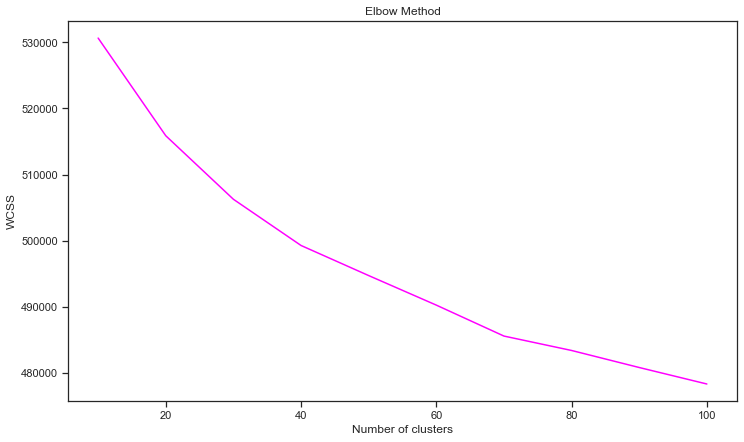

In [205]:
# Elbow Plot
plt.figure(figsize=(12,7))
plt.plot(range(10, 101, 10), wcss_grand['X_train_cv_wcss'], color = 'magenta')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Visualizing and Comparing Clusters

Sample the data, then for reproducibility set a random state.

In [250]:
# For 5 clusters
ten_clust = pd.DataFrame({'data': processed_X_train,'original': original, 'labels': labels[6]}).sort_values('labels',ignore_index = True)
six_clust = pd.DataFrame({'data': processed_X_train,'labels': labels[3]})

In [253]:
ten_clust.to_csv('ten_clust.csv') # Storing to CSV to view results
ten_clust[ten_clust['labels'] == 0]

,data,original,labels
0,"[yep, i, have, thought, app, site, fault, yikes]",@285455 Yep - I've had that too. I thought it ...,0
1,"[still, waiting, order, status, change, order,...",Still waiting for my order status to change fr...,0
2,"[using, #ios11, ipadair, 2, conclude, ruined, ...","After a while using #ios11 on my iPadAir2, I c...",0
3,"[1st, messages, deleted, pics, gone, wtf, get,...",1st all my messages deleted now all my pics ar...,0
4,"[hi, want, view, us, app, store, i, am, uk, on...",@AppleSupport Hi I want to view the US app sto...,0
...,...,...,...
15816,"[help, please, every, time, ️, type, letter, ️...",@AppleSupport Help please every time i️ type t...,0
15817,"[say, 7hrs, .., pretty, awful, ask, :(]",@AppleSupport I’d say about 7hrs.. which is pr...,0
15818,"[stop, ️, swearr, tooo, god, sound, bad, atm, ...",IF THIS DOES NOT STOP I️ SWEARR TOOO GOD @1158...,0
15819,"[man, ️, keep, popping, type, letter, comes, h...",Man why do this “ I️ “keep popping up when we...,0


In [252]:
ten_clust[ten_clust['labels'] == 1]

,data,original,labels
15821,"[11.1, 2, still, fixed, many, bug, issues, iph...",@AppleSupport 11.1.2 still hasn’t fixed many o...,1
15822,"[got, brand, new, iphone, 8, plus, stuck, reco...",I’ve got a brand new @115858 iPhone 8 Plus tha...,1
15823,"[iphone, 6s, battery, life, completely, crappe...",My iPhone 6S battery life has completely crapp...,1
15824,"[iphone, 8, plus, problem, speakers, sound, ev...",@AppleSupport iphone 8 plus I have a problem w...,1
15825,"[iphone, 5s, keeps, dying, 40, snapchat, app, ...",@AppleSupport iPhone 5S keeps dying on 40%+ wh...,1
...,...,...,...
22285,"[iphone, trippin, mane, cause, want, go, buy, ...","@115858 why my iphone trippin mane, it’s cause...",1
22286,"[tried, see, pic, iphone, x, showing, corner, ...",@AppleSupport I tried that but if you can see ...,1
22287,"[wanna, able, change, screen, gestures, iphone...",I wanna be able to change the screen gestures ...,1
22288,"[iphone, hangs, lot, ..., really, reason, ...,...",@AppleSupport My iPhone hangs a lot....I reall...,1


In [39]:
ten_clust[ten_clust['labels'] == 2]

NameError: name 'ten_clust' is not defined

Each cluster is specific

### K-Means with glove doc2vec embedded vectorized data

K Means expects the dimensionality is the same between all elements.

In [96]:
X_train_glove.shape

(63412,)

In [93]:
# 19 words, each word is represented by an array of size 25
X_train_glove.iloc[0].shape

(19, 25)

In [98]:
X_train_glove.iloc[1].shape

(14, 25)

In [104]:
X_train_glove.iloc[2].shape

(10, 25)

In [105]:
X_train_glove.iloc[3].shape

(19, 25)

K-Means clustering is struggling because you are passing in multiple arrays with different words, and each word has a different vector. Rather than encoding each Tweet with words. Doc2Vec converts the entire document into one vector.

## How do you check how it's performing, visualizing with PCA and t-SNE

Gensim containts pretrained word embeddings and load them in. They have a special data format where you can basically load it in as a numpy array. Word2Vec is a NN architecture which basically trains Word2Vec method to generate word embeddings.

Someone has run this on a massive data and released the embeddings the model learned on the internet. Takes in various website and different contexts with learning. When you trained it to learn the words from like academic papers, the meaning of the word it learns is different than general twitter data. But a good thing about the word embeddigns is that they are usualyl trained on pretrained.

Glove is another algorithm for calculating word vectors. BERT, etc. Fast text is quite popular as well. You'll get some kind of file with those words and you'll basically generate this word-to-word embedding matrix and you pass it in as the weights layer in your NN.

Starting with K-Means. Use Scikitlearn's tokenizer. Transform the text into vector representation like tfidf or CountVectorizer. You have a matrix of all your rows, you have your pretrained word embeddings, you'll have to manually match up each word with the word vector.



When you build NN, when you use K fold it will take a LONG time so you can probably get away without doing CV with your NN and hyperparamater optimization. These embedding transformer has pretrained word embeddings, it will fit the data with that.

Do more exploration on your data. Sometimes when you have NLTK on tweets it gets weird. Because they have been trained on actual text.

## 2. LDA (Latent Dirichlet Allocation)
My second approach for the clustering is LDA topic modelling (Latent Dirichlet Allocation). It basically takes your data and splits it into topics. My goal is still to cluster, but with this method I hope to get more useful, distinct topics.

Useful article:
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# 3. DBSCAN

For time constraint's sake, I decided not to use DBScan because they will achieve a clustering result similar to K-Means. I could have also use Gaussian Mixed Models or Heirarchical Clustering to achieve this clustering result.